In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
sys.path.insert(0, '/home/jovyan/mne-python/')
import pickle
import warnings
warnings.filterwarnings("ignore", message="y_pred contains classes not")

from IPython.display import display
import torch
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_color_codes('deep')
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.metrics import mean_absolute_error, mean_squared_error, balanced_accuracy_score

from braindecode.datasets.tuh import TUHAbnormal
from braindecode.preprocessing import create_fixed_length_windows

from decode_tueg import (
    DataScaler, TargetScaler, trial_age_mae, Augmenter, ChannelsSymmetryFB,
    get_datasets, test_name, create_windows, create_final_scores,
    plot_age_gap_hist, plot_violin, accuracy_perumtations, 
    plot_thresh_to_acc, age_gap_diff_permutations,
    plot_learning_curves, save_fig, read_result,
    load_exp, predict_ds, plot_heatmaps, plot_age_gap_hist_and_permutation_test,
    plot_age_gap_hist_with_thresh_and_permutation_test,
)

<ipython-input-2-7045910767a8>:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
# TODO: 
# mail denis
# mail joschka
# check offdiagonal age sources gap
# improve handling of cv / final eval in this notebook
# rename eval back to valid? makes things easier
# always compute mean over folds and afterwards over seeds?
# accept a thresh as input (valid for eval)

In [4]:
# work_dir = '/home/jovyan/workspace-tueg/'
work_dir = '/home/lukas/Code/brain_age/'

In [5]:
base_dir = os.path.join(work_dir, 'experiments')
# exp = '2022-10-07T14:07:06.646966'  # deep all ages, lr=0.005
# exp = '2022-10-06T09:37:01.278443'  # deep all ages, lr=0.01
# exp = '2022-10-05T14:36:25.074269'  # shallow all ages
# exp = '2022-09-28T10:25:47.571160'  # shallow ages >= 18
# exp = '2022-09-28T22:24:18.385389'  # TCN all ages, still with 'valid_rest'
# exp = '2022-10-06T20:10:52.312837'  # TCN all ages, 5 seeds
exp = '2022-10-12T11:25:00.490417'  # TCN exluding recs with age divergence
# exp = '2022-09-29T15:49:14.606557'  # TCN ages >= 18
# exp = '2022-10-08T08:04:26.625918'  # TCN matched patho and non-patho dist in all ages
# exp = '2022-10-09T09:55:45.307781'  # TCN uniformly matched patho and non-patho age dist in >=18 and <=86
# exp = '2022-10-09T12:02:46.142332'  # TCN all ages, sign augmentation isntead of dropout
# exp = '2022-10-12T08:10:43.911642'  # TCN all ages age_clf

#exp = '2022-10-17T16:24:10.124445'  # TCN exluding recs with age divergence, final eval
exp_dir = os.path.join(base_dir, exp)

In [6]:
configs = read_result(exp_dir, 'config')

In [7]:
configs

,augment,batch_size,data_path,date,debug,fast_mode,final_eval,intuitive_training_scores,loss,max_age,...,squash_outs,standardize_data,standardize_targets,subset,target_name,tmin,tmax,valid_set_i,window_size_samples,run_name
0,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-12T11:25:00.490417,1,1,0,1,mae,-1,...,1,1,1,normal,age,60,-1,0,6000,decode_age
1,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-12T11:25:00.490417,1,1,0,1,mae,-1,...,1,1,1,normal,age,60,-1,1,6000,decode_age
2,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-12T11:25:00.490417,1,1,0,1,mae,-1,...,1,1,1,normal,age,60,-1,2,6000,decode_age
3,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-12T11:25:00.490417,1,1,0,1,mae,-1,...,1,1,1,normal,age,60,-1,3,6000,decode_age
4,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-12T11:25:00.490417,1,1,0,1,mae,-1,...,1,1,1,normal,age,60,-1,4,6000,decode_age
0,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-12T11:25:00.490417,1,1,0,1,mae,-1,...,1,1,1,normal,age,60,-1,0,6000,decode_age
1,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-12T11:25:00.490417,1,1,0,1,mae,-1,...,1,1,1,normal,age,60,-1,1,6000,decode_age
2,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-12T11:25:00.490417,1,1,0,1,mae,-1,...,1,1,1,normal,age,60,-1,2,6000,decode_age
3,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-12T11:25:00.490417,1,1,0,1,mae,-1,...,1,1,1,normal,age,60,-1,3,6000,decode_age
4,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-12T11:25:00.490417,1,1,0,1,mae,-1,...,1,1,1,normal,age,60,-1,4,6000,decode_age


In [8]:
assert configs['final_eval'].nunique() == 1

In [9]:
configs[['model_name', 'target_name', 'valid_set_i', 'seed']]

,model_name,target_name,valid_set_i,seed
0,tcn,age,0,20220429
1,tcn,age,1,20220429
2,tcn,age,2,20220429
3,tcn,age,3,20220429
4,tcn,age,4,20220429
0,tcn,age,0,20221014
1,tcn,age,1,20221014
2,tcn,age,2,20221014
3,tcn,age,3,20221014
4,tcn,age,4,20221014


In [10]:
scores = read_result(exp_dir, 'score')

In [11]:
if (configs['final_eval'] == '1').all():
    display(scores.loc[['mae']].mean())
else:
    display(scores.loc[['mae']].groupby('seed').mean())

,train,valid,valid_not_normal,valid_set_i
seed,,,,
20220429,2.473640,6.759536,11.335201,2.0
20221014,2.550661,6.705875,11.401129,2.0


In [12]:
histories = read_result(exp_dir, 'history')

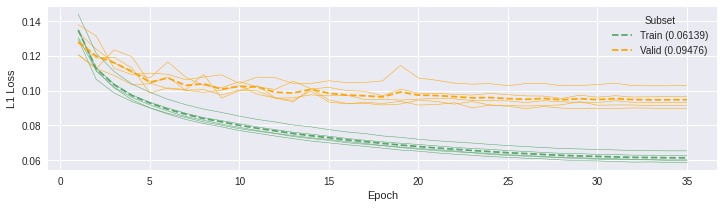

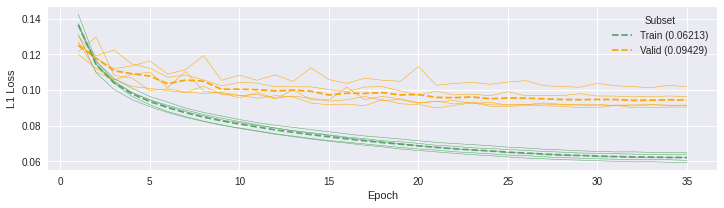

In [13]:
if (configs['final_eval'] == '1').all():
    histories['eval_run_i'] = (histories['epoch'] == 1).cumsum() - 1
    ax = plot_learning_curves([g2 for n2, g2 in histories.groupby('eval_run_i')], 'L1 Loss', 'Eval')
    ax.get_figure().savefig(os.path.join(work_dir, 'final_eval_curves.png'), dpi=300, bbox_inches='tight')
else:
    for n1, g1 in histories.groupby('seed'):
        ax = plot_learning_curves([g2 for n2, g2 in g1.groupby('valid_set_i')], 'L1 Loss')
        # ax.set_title(f'Deep4, lr=0.005')
        # ax.set_title(f'Seed: {n1}')
        ax.get_figure().savefig(os.path.join(work_dir, f'cv_curves_{n1}.png'), dpi=300, bbox_inches='tight')

In [14]:
preds = read_result(exp_dir, 'preds')

In [15]:
accs = []
for n1, g1 in preds.groupby('seed'):
    acc = balanced_accuracy_score(g1.y_true.to_numpy().astype(int), g1.y_pred.to_numpy().astype(int))
    accs.append(acc)
mean_acc = np.mean(accs)
mean_acc

0.03636450670154515

In [16]:
bin_size = 2
max_age = 100
# hist_max_count = 12#220

In [17]:
# TODO: mae here does not match mae from scores? why? fix
# it's due to the computation. scores are computed per fold and then averaged
# in plot below all preds of all folds are plotted and score computed on all of them
# which one to prefer?

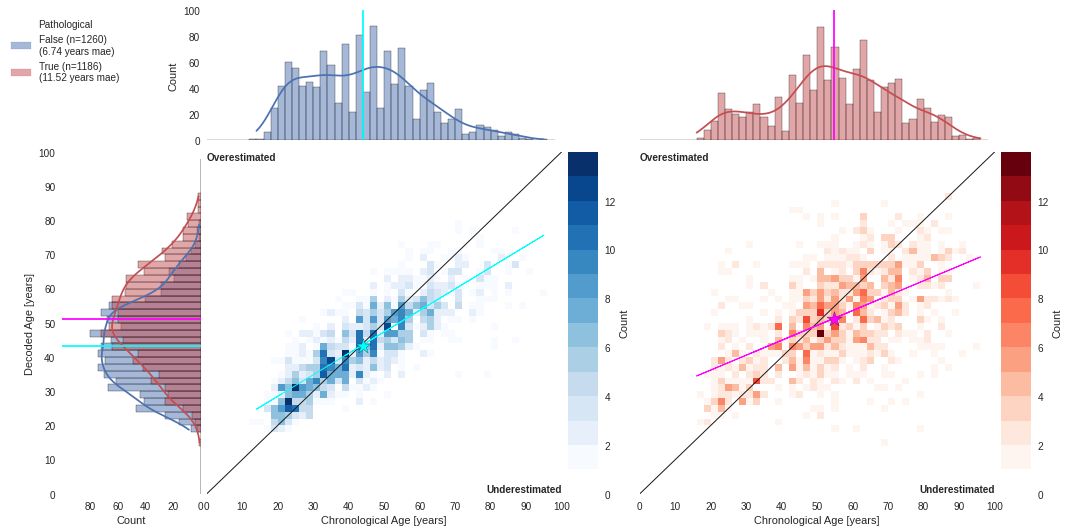

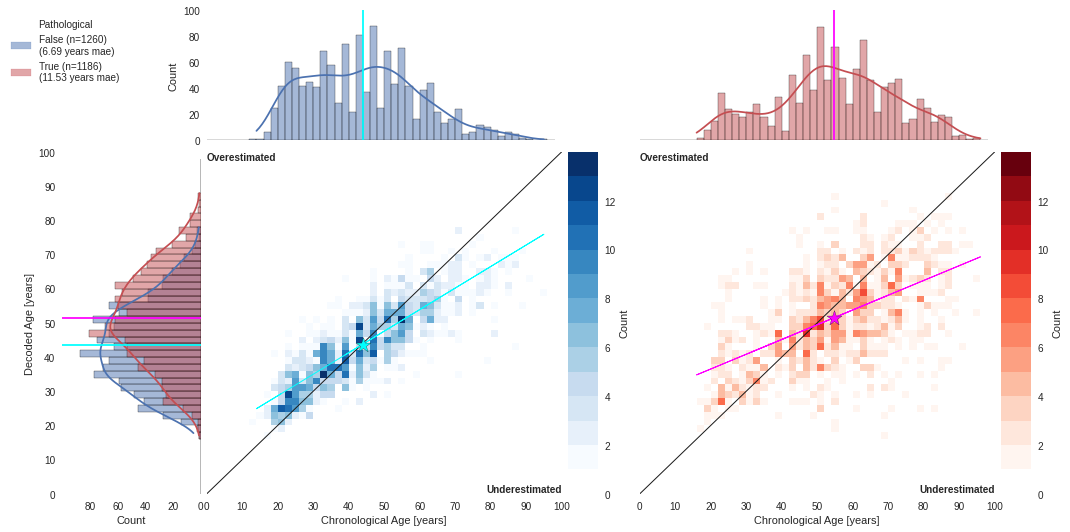

In [18]:
if (configs['final_eval'] == '1').all():
    cols = ['y_pred', 'y_true', 'pathological', 'index', 'subset']
    this_preds = preds.reset_index()[cols].groupby(['index', 'subset'], as_index=False).mean()
    fig = plot_heatmaps(this_preds, bin_size, max_age, 12)
    fig.savefig(os.path.join(work_dir, 'final_eval_chronological_vs_predicted_age.png'), 
                            dpi=300, bbox_inches='tight')
else:
    for n1, g1 in preds.groupby('seed'):
        fig = plot_heatmaps(g1, bin_size, max_age, 100)
        #fig.suptitle(f'Seed: {n1}', y=.9)
        fig.savefig(os.path.join(work_dir, f'cv_chronological_vs_predicted_age_{n1}.png'), 
                            dpi=300, bbox_inches='tight')

In [19]:
bin_width = 2
n_repetitions = 100000

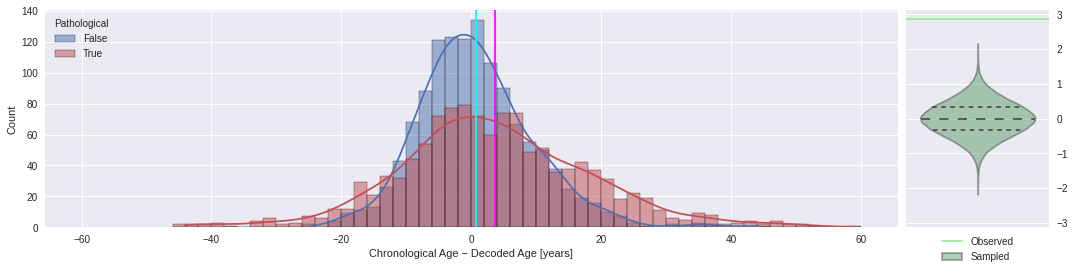

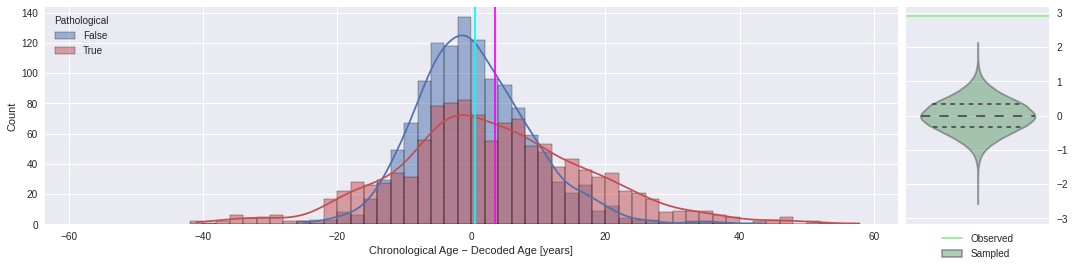

In [20]:
if (configs['final_eval'] == '1').all():
    cols = ['y_pred', 'y_true', 'pathological', 'gap', 'subject', 'index', 'subset']
    this_preds = preds.reset_index()[cols].groupby(['index', 'subset'], as_index=False).mean()
    
    ax = plot_age_gap_hist_and_permutation_test(
        this_preds,
        bin_width, n_repetitions,
    )
    
#     ax.set_title(f'Subject-wise Pathological and Non-Pathological Brain Age Gap (Seed: {n1})')
    ax.get_figure().savefig(os.path.join(work_dir, 'final_eval_brain_age_gap_and_permutation_test.png'), 
                            dpi=300, bbox_inches='tight')
else:
    for n1, g1 in preds.groupby('seed'):

        plot_age_gap_hist_and_permutation_test(
            g1,
            bin_width, n_repetitions,
        )
        
        # ax.set_title(f'Subject-wise Pathological and Non-Pathological Brain Age Gap (Seed: {n1})')
        ax.get_figure().savefig(os.path.join(work_dir, f'cv_brain_age_gap_and_permutation_test_{n1}.png'), 
                            dpi=300, bbox_inches='tight')
        # ax.set_title(f'Seed: {n1}')
        # ax.set_title('Mean Subject-wise Difference of Pathological and Non-Pathological Brain Age Gap');

In [21]:
bin_width = 2
min_age, max_age = 0, 100

-11.837134346365925 6.392848491668701
62.19732862228646
-13.607841700315475 8.30575579404831
62.68128161888702


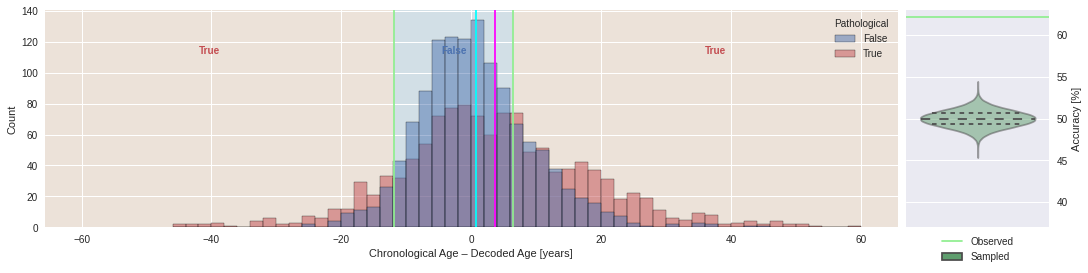

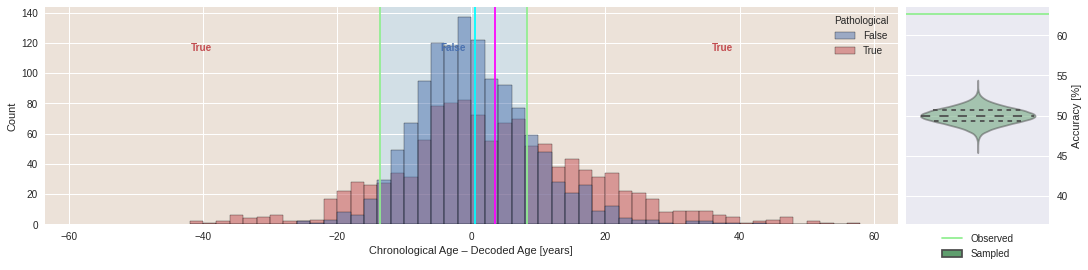

In [22]:
if (configs['final_eval'] == '1').all():
    cols = ['y_pred', 'y_true', 'pathological', 'gap', 'subject', 'index', 'subset']
    this_preds = preds.reset_index()[cols].groupby(['index', 'subset'], as_index=False).mean()
    
    plot_age_gap_hist_with_thresh_and_permutation_test(
        (this_preds[(this_preds.y_true >= min_age) & (this_preds.y_true <= max_age)]),
        bin_width, n_repetitions,
    )
else:
    for n1, g1 in preds.groupby('seed'):
        plot_age_gap_hist_with_thresh_and_permutation_test(
            g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)],
            bin_width, n_repetitions,
        )
        #ax.set_title('Brain Age Gap Pathology Proxy')
        #ax.get_figure().savefig(os.path.join(work_dir, f'cv_gap_proxy_{n1}.png'), 
        #                        dpi=300, bbox_inches='tight')

In [26]:
balanced_accuracy_score(g1.pathological, g1['gap'] > 5.405104780197144)

0.5804852913621885

In [28]:
balanced_accuracy_score(g1.pathological, (g1['gap'] > 5.405104780197144) | (g1['gap'] < -8.302439975738))

0.6011610321475414

20220429


KeyboardInterrupt: 

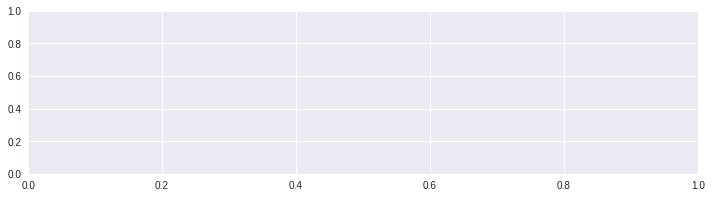

In [25]:
min_age, max_age = 0, 100
if (configs['final_eval'] == '1').all():
    cols = ['y_pred', 'y_true', 'pathological', 'gap', 'subject', 'index', 'subset']
    this_preds = preds.reset_index()[cols].groupby(['index', 'subset'], as_index=False).mean()
    ax = plot_thresh_to_acc(this_preds[(this_preds.y_true >= min_age) & (this_preds.y_true <= max_age)])
    ax.set_title('')
    ax.get_figure().savefig(os.path.join(work_dir, f'final_eval_gap_proxy.png'), 
                            dpi=300, bbox_inches='tight')
else:
    for n1, g1 in preds.groupby('seed'):
        print(n1)
        ax = plot_thresh_to_acc(g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)] )
        ax.set_title('Brain Age Gap Pathology Proxy')
        ax.get_figure().savefig(os.path.join(work_dir, f'cv_gap_proxy_{n1}.png'), 
                                dpi=300, bbox_inches='tight')

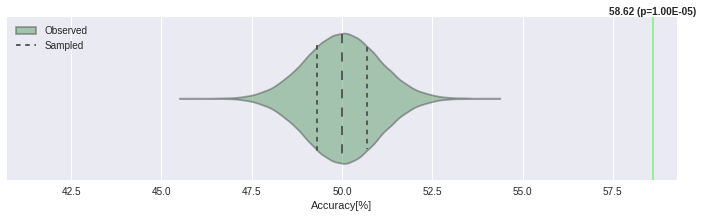

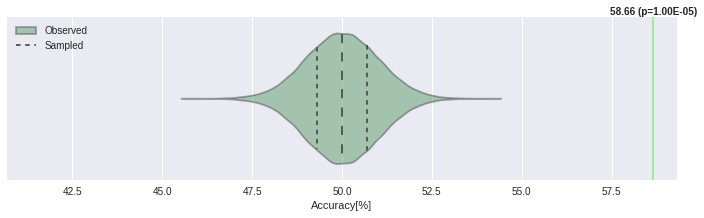

In [23]:
if (configs['final_eval'] == '1').all():
    this_preds = preds.reset_index()[['y_pred', 'y_true', 'pathological', 'gap', 'subject', 'index', 'subset']].groupby(['index', 'subset'], as_index=False).mean()
    observed, sampled = accuracy_perumtations(this_preds, n_repetitions)
    ax = plot_violin(
        observed,
        sampled,
        xlabel='Accuracy[%]',
        center_value=50,
    )
    ax.get_figure().savefig(os.path.join(work_dir, f'final_eval_proxy_permutations.png'), 
                            dpi=300, bbox_inches='tight')
else:
    for n1, g1 in preds.groupby('seed'):
        observed, sampled = accuracy_perumtations(g1, n_repetitions)
        ax = plot_violin(
            observed,
            sampled,
            xlabel='Accuracy[%]',
            center_value=50,
        )
        # ax.get_figure().savefig('/home/jovyan/permutation_test_proxy.png', bbox_inches='tight', dpi=300)
        ax.get_figure().savefig(os.path.join(work_dir, f'cv_proxy_permutations_{n1}.png'), 
                                dpi=300, bbox_inches='tight')

<ipython-input-22-c8b7d40f2625>:34: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot2grid((3, 20), (0, 0), rowspan=3, colspan=18)


KeyboardInterrupt: 

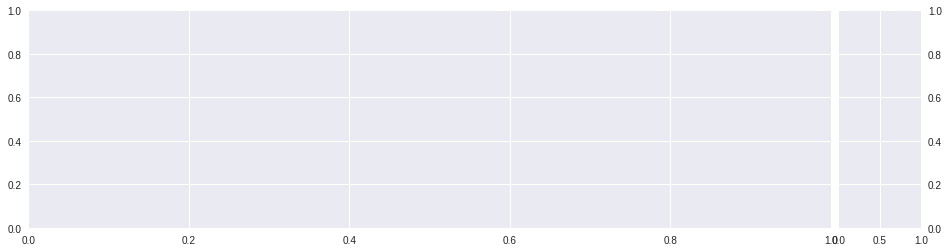

In [22]:
min_age, max_age = 0, 100
if (configs['final_eval'] == '1').all():
    cols = ['y_pred', 'y_true', 'pathological', 'gap', 'subject', 'index', 'subset']
    this_preds = preds.reset_index()[cols].groupby(['index', 'subset'], as_index=False).mean()

    fig, ax = plt.subplots(1, 1, figsize=(16, 4))
    ax0 = plt.subplot2grid((3, 20), (0, 0), rowspan=3, colspan=18)
    ax1 = plt.subplot2grid((3, 20), (0, 18), rowspan=3, colspan=3)
    ax1.yaxis.tick_right()
    ax1.yaxis.set_label_position("right")

    plot_thresh_to_acc(this_preds[(this_preds.y_true >= min_age) & (this_preds.y_true <= max_age)], ax=ax0)
    observed, sampled = accuracy_perumtations(this_preds, n_repetitions)

    ax0.set_title('')
    ax1.axhline(observed, c='lightgreen')
    sns.violinplot(y=sampled, ax=ax1, inner='quartile', color='g')
    ax1.legend(['Observed', 'Sampled'], loc='lower center', bbox_to_anchor=(.5, -.2))
    ax1.set_ylabel('Accuracy [%]')
    # set violin alpha = .5
    # https://github.com/mwaskom/seaborn/issues/622
    from matplotlib.collections import PolyCollection
    for art in ax1.get_children():
        if isinstance(art, PolyCollection):
            art.set_alpha(.5)
            
    #ax = plot_thresh_to_acc(this_preds[(this_preds.y_true >= min_age) & (this_preds.y_true <= max_age)])
    #ax.set_title('')
    #ax.get_figure().savefig(os.path.join(work_dir, f'final_eval_gap_proxy.png'), 
    #                        dpi=300, bbox_inches='tight')
else:
    for n1, g1 in preds.groupby('seed'):
        fig, ax = plt.subplots(1, 1, figsize=(16, 4))
        ax0 = plt.subplot2grid((3, 20), (0, 0), rowspan=3, colspan=18)
        ax1 = plt.subplot2grid((3, 20), (0, 18), rowspan=3, colspan=3)
        ax1.yaxis.tick_right()
        ax1.yaxis.set_label_position("right")

        plot_thresh_to_acc(g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)], ax=ax0)
        observed, sampled = accuracy_perumtations(g1, n_repetitions)

        ax0.set_title('')
        ax1.axhline(observed, c='lightgreen')
        sns.violinplot(y=sampled, ax=ax1, inner='quartile', color='g')
        ax1.legend(['Observed', 'Sampled'], loc='lower center', bbox_to_anchor=(.5, -.2))
        ax1.set_ylabel('Accuracy [%]')
        # set violin alpha = .5
        # https://github.com/mwaskom/seaborn/issues/622
        from matplotlib.collections import PolyCollection
        for art in ax1.get_children():
            if isinstance(art, PolyCollection):
                art.set_alpha(.5)

        #ax = plot_thresh_to_acc(g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)] )
        #ax.set_title('Brain Age Gap Pathology Proxy')
        #ax.get_figure().savefig(os.path.join(work_dir, f'cv_gap_proxy_{n1}.png'), 
        #                        dpi=300, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16,4))
ax0 = plt.subplot2grid((3, 20), (0, 0), rowspan=3, colspan=18)
ax1 = plt.subplot2grid((3, 20), (0, 18), rowspan=3, colspan=3)
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")

plot_thresh_to_acc(this_preds[(this_preds.y_true >= min_age) & (this_preds.y_true <= max_age)], ax=ax0)
observed, sampled = accuracy_perumtations(this_preds, n_repetitions)

ax0.set_title('')
ax1.axhline(observed, c='lightgreen')
sns.violinplot(y=sampled, ax=ax1, inner='quartile', color='g')
ax1.legend(['Observed', 'Sampled'], loc='lower center', bbox_to_anchor=(.5, -.2))
ax1.set_ylabel('Accuracy [%]')
# set violin alpha = .5
# https://github.com/mwaskom/seaborn/issues/622
from matplotlib.collections import PolyCollection
for art in ax1.get_children():
    if isinstance(art, PolyCollection):
        art.set_alpha(.5)

__analyze preds with targets >= 18 years -> improvement?__

In [151]:
hist_max_count = 60

In [152]:
preds = preds[preds.y_true >= 18]

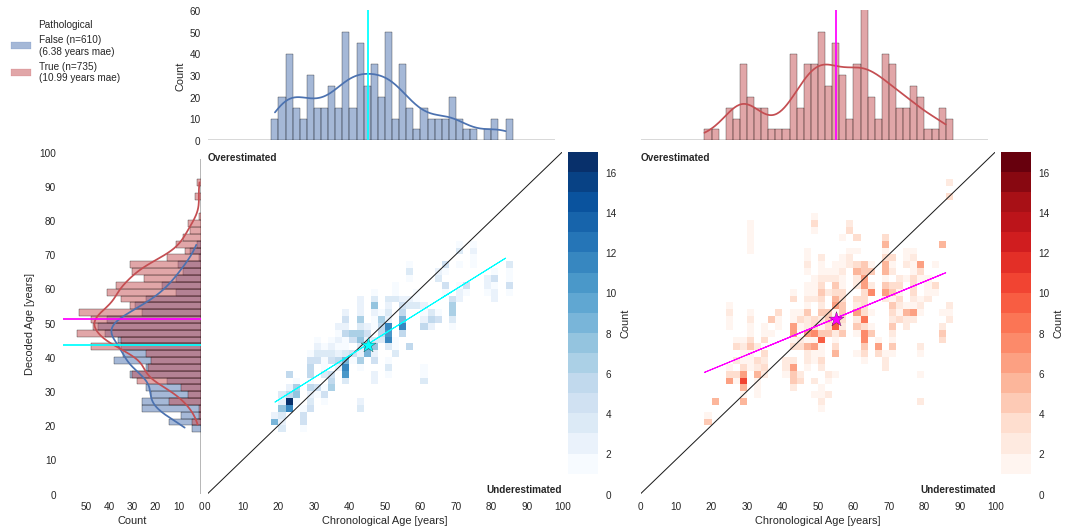

In [153]:
fig = plot_heatmaps(preds, bin_size, max_age, hist_max_count)
# fig.savefig('/home/jovyan/new2dhist.png', bbox_inches='tight', dpi=300)

Text(0.5, 1.0, 'Subject-wise Pathological and Non-Pathological Brain Age Gap')

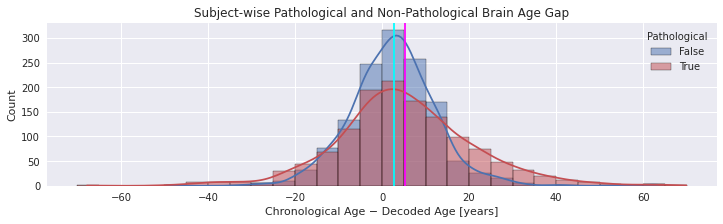

In [30]:
ax = plot_age_gap_hist(preds)
ax.set_title('Subject-wise Pathological and Non-Pathological Brain Age Gap')

Text(0.5, 1.0, 'Mean Subject-wise Difference of Pathological and Non-Pathological Brain Age Gap')

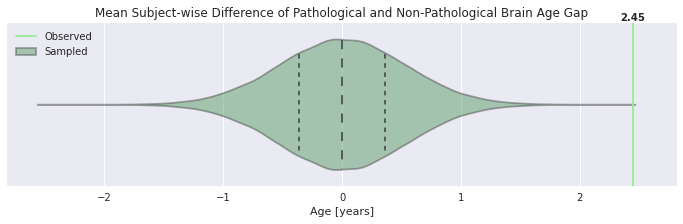

In [31]:
ax = plot_violin(
    *age_gap_diff_permutations(preds, n_repetitions, True), 
    'Age [years]',
)
ax.set_title('Mean Subject-wise Difference of Pathological and Non-Pathological Brain Age Gap')

2015
7.835325027544705


Text(0.5, 1.0, 'Brain Age Gap Pathology Proxy')

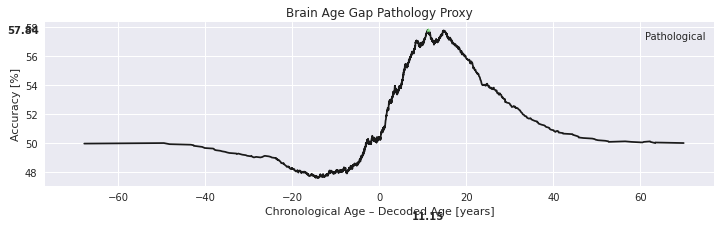

In [45]:
ax = plot_thresh_to_acc(preds)
ax.set_title('Brain Age Gap Pathology Proxy')

2015
7.835325027544705


Text(0.5, 1.0, 'Brain Age Gap Pathology Proxy')

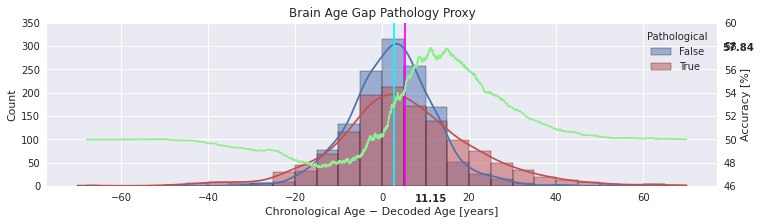

In [124]:
ax1 = plot_age_gap_hist(preds)
ax2 = ax1.twinx()
ax1.set_yticks(ax1.get_yticks())
ax2 = plot_thresh_to_acc(preds, ax=ax2)
ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax1.get_yticks())))
ax2.grid(None)
ax2.legend()
ax1.set_title('Brain Age Gap Pathology Proxy')
#ax1.set_xlabel('Chronological Age – Decoded Age [years]')
# ax2.axhline(50, linestyle='-', c='k', linewidth=1)

In [96]:
ages = [0, 18, 30, 60, 80, 100]

In [97]:
age_limits = [(ages[i], ages[j]) for i in range(len(ages)-1) for j in range(i+1, len(ages))]

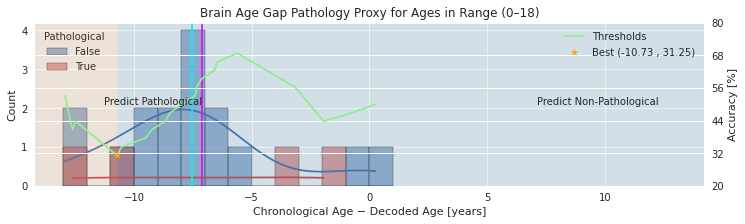

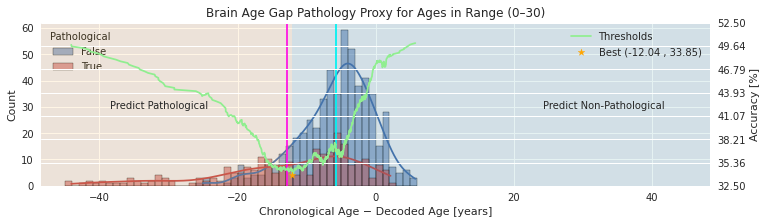

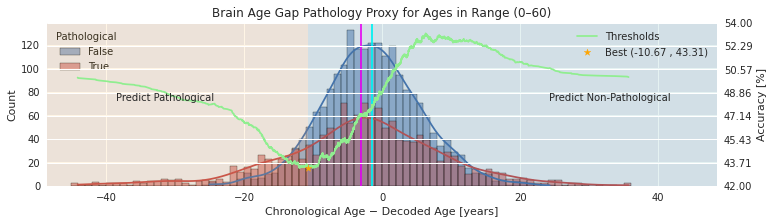

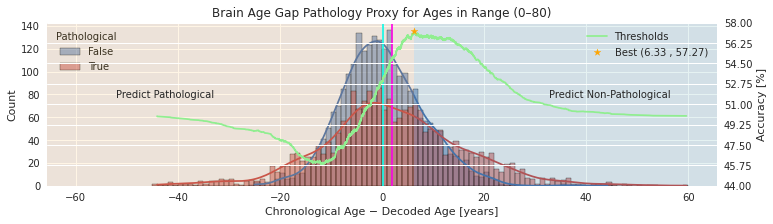

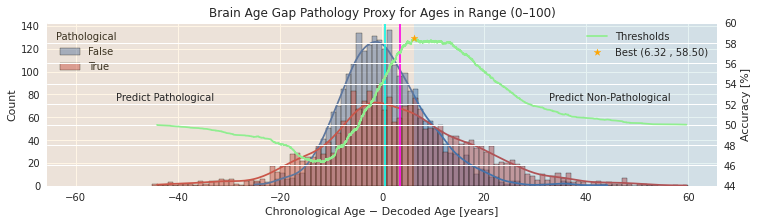

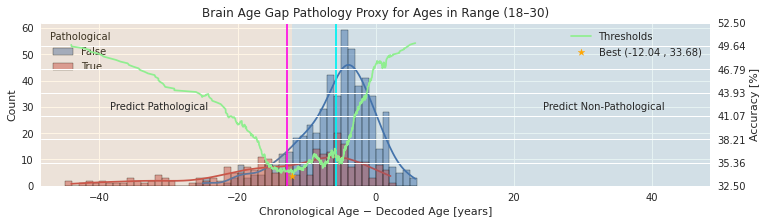

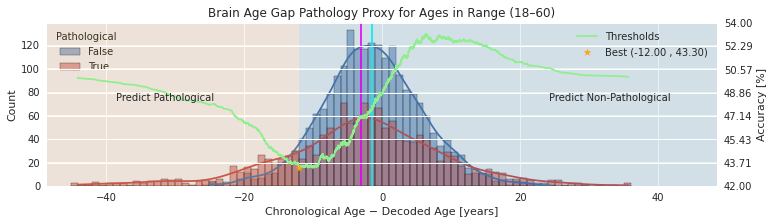

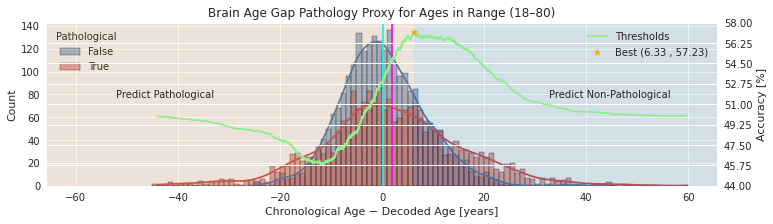

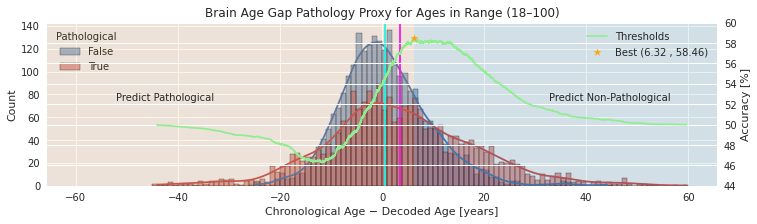

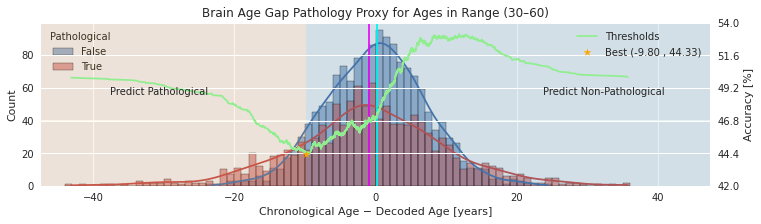

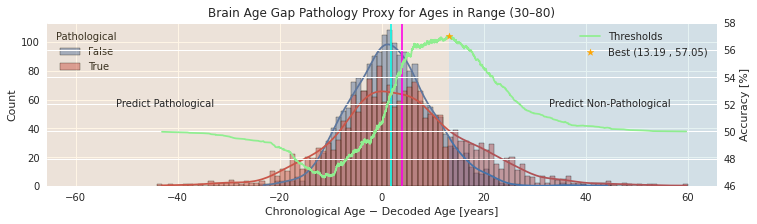

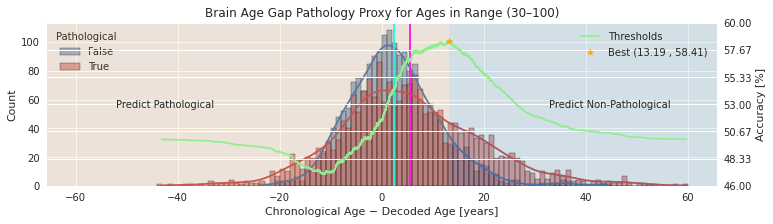

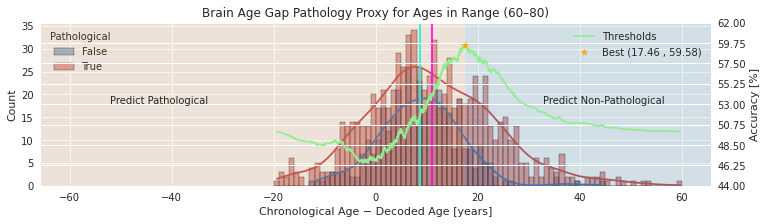

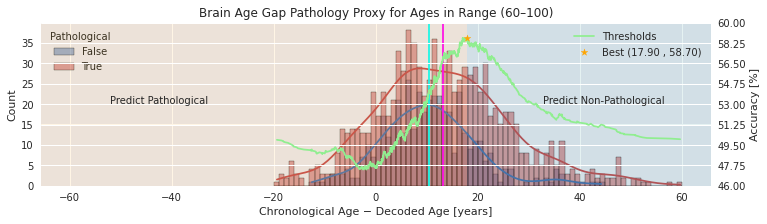

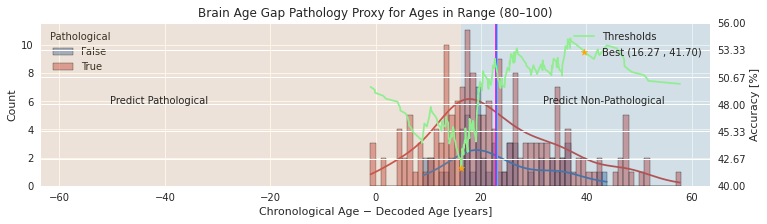

In [98]:
for min_age, max_age in age_limits:
    ax2 = plot_thresh_to_acc(preds[(preds.y_true >= min_age) & (preds.y_true < max_age)])
    ax2.set_title(ax2.get_title() + f' for Ages in Range ({min_age}–{max_age})')